In [1]:
import torch
import numpy as np
import os
os.chdir('..')

import torch_converter as tc
import instance_generator as ig
from torch_geometric.loader import DataLoader
from gnn_library.util import train, save, load
from util import NumpyDataset, Dataset
from evaluate import evaluate_model, pp_output
import evaluate as ev
from gnn_library.OBM_greedy import OBM_Greedy


%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device('cuda:7' if torch.cuda.is_available() else 'cpu')
print("PyTorch has version {}".format(torch.__version__))
print('Using device:', device)

PyTorch has version 2.0.0+cu117
Using device: cuda:7


In [3]:
GNN1, args1 = load('GNN1_hyperparam_tuned', device)
GNN2, args2 = load('GNN2_hyperparam_tuned', device)
# GNN3, args3 = load('GNN3', device)
GREEDY = OBM_Greedy()

### I. Meta GNN training/evaluation

In [138]:
args = {
    'processor':         'TEST2',
    'head':              'meta',
    'num_layers':        4,
    'num_mlp_layers':    2,
    'aggr':              'max',
    'batch_size':        6,
    'node_feature_dim':  7,
    'edge_feature_dim':  1,
    'graph_feature_dim': 2,
    'hidden_dim':        8,
    'output_dim':        2,
    'head_mlp_dim':      8,
    'dropout':           0,
    'epochs':            35,
    'opt':               'adam',
    'opt_scheduler':     'none',
    'opt_restart':       0,
    'weight_decay':      5e-3,
    'lr':                0.001,
    'device':            device
}

train_num = 150; test_num = 50

er_config = {
    'graph_type': 'ER',
    'p': 1,
    'weighted': True
}
ba_config = {
    'graph_type': 'BA',
    'ba_param': 4,
    'weighted': False
}
geom_config = {
    'graph_type': 'GEOM',
    'q': 0.25,
    'd': 2,
    'weighted': True
}

rng = np.random.default_rng()

train_instances = [
    *ig.sample_instances(6, 10, train_num, rng, args, **er_config),
    *ig.sample_instances(6, 10, train_num, rng, args, **ba_config),
    *ig.sample_instances(6, 10, train_num, rng, args, **geom_config),
    *ig.sample_instances(8, 8, train_num, rng, args, **er_config),
    *ig.sample_instances(8, 8, train_num, rng, args, **ba_config),
    *ig.sample_instances(8, 8, 4*train_num, rng, args, **geom_config),
    *ig.sample_instances(10, 6, train_num, rng, args, **er_config),
    *ig.sample_instances(10, 6, train_num, rng, args, **ba_config),
    *ig.sample_instances(10, 6, train_num, rng, args, **geom_config)
]


test_instances = [
    *ig.sample_instances(6, 10, test_num, rng, args, **er_config),
    *ig.sample_instances(6, 10, test_num, rng, args, **ba_config),
    *ig.sample_instances(6, 10, test_num, rng, args, **geom_config),
    *ig.sample_instances(8, 8, test_num, rng, args, **er_config),
    *ig.sample_instances(8, 8, test_num, rng, args, **ba_config),
    *ig.sample_instances(8, 8, 4*test_num, rng, args, **geom_config),
    *ig.sample_instances(10, 6, test_num, rng, args, **er_config),
    *ig.sample_instances(10, 6, test_num, rng, args, **ba_config),
    *ig.sample_instances(10, 6, test_num, rng, args, **geom_config)
]

train_data = Dataset(
    tc._instances_to_train_samples(
        instances=train_instances,
        head=args['head'],
        meta_model_type='gnn',
        base_models=[GNN1, GNN2]
    )
)

test_data = Dataset(
    tc._instances_to_train_samples(
        instances=test_instances,
        head=args['head'],
        meta_model_type='gnn',
        base_models=[GNN1, GNN2]
    )
)

train_loader = DataLoader(
    train_data,
    batch_size=args['batch_size'],
    shuffle=True,
    num_workers=4
)

test_loader = DataLoader(
    test_data,
    batch_size=args['batch_size'],
    shuffle=True,
    num_workers=4
)

In [142]:
_, _, _, META_GNN, _ = train(train_loader, test_loader, args)

Training:   0%|          | 0/35 [00:00<?, ?Epochs/s]

TRAINING LOSS: 0.68350521008545


Training:   3%|▎         | 1/35 [00:10<05:47, 10.23s/Epochs]

TEST LOSS: 0.6769979000091553
TEST ACCURACY: 0.0


Training:   6%|▌         | 2/35 [00:18<05:04,  9.23s/Epochs]

TRAINING LOSS: 0.6487553242211029


Training:   9%|▊         | 3/35 [00:27<04:50,  9.08s/Epochs]

TRAINING LOSS: 0.632248722086443


Training:  11%|█▏        | 4/35 [00:35<04:29,  8.68s/Epochs]

TRAINING LOSS: 0.6059623295180151
TRAINING LOSS: 0.5946394117357575


Training:  14%|█▍        | 5/35 [00:45<04:33,  9.11s/Epochs]

TEST LOSS: 0.5987833142280579
TEST ACCURACY: 0.0


Training:  17%|█▋        | 6/35 [00:53<04:14,  8.77s/Epochs]

TRAINING LOSS: 0.5957298532267598


Training:  20%|██        | 7/35 [01:02<04:01,  8.62s/Epochs]

TRAINING LOSS: 0.590675964812252


Training:  23%|██▎       | 8/35 [01:10<03:51,  8.57s/Epochs]

TRAINING LOSS: 0.5860532380153085
TRAINING LOSS: 0.5853693755430596


Training:  26%|██▌       | 9/35 [01:20<03:58,  9.16s/Epochs]

TEST LOSS: 0.5944114923477173
TEST ACCURACY: 0.0


Training:  29%|██▊       | 10/35 [01:28<03:39,  8.77s/Epochs]

TRAINING LOSS: 0.5850715981187108


Training:  31%|███▏      | 11/35 [01:37<03:26,  8.61s/Epochs]

TRAINING LOSS: 0.5839925777410793


Training:  34%|███▍      | 12/35 [01:45<03:17,  8.58s/Epochs]

TRAINING LOSS: 0.5838127654289531
TRAINING LOSS: 0.5839621813219285


Training:  37%|███▋      | 13/35 [01:56<03:25,  9.33s/Epochs]

TEST LOSS: 0.5880095362663269
TEST ACCURACY: 0.0


Training:  40%|████      | 14/35 [02:05<03:11,  9.14s/Epochs]

TRAINING LOSS: 0.5826240626172484


Training:  43%|████▎     | 15/35 [02:12<02:53,  8.68s/Epochs]

TRAINING LOSS: 0.5821763919057134


Training:  46%|████▌     | 16/35 [02:21<02:44,  8.64s/Epochs]

TRAINING LOSS: 0.582158056235759
TRAINING LOSS: 0.5821863575794987


Training:  49%|████▊     | 17/35 [02:32<02:46,  9.24s/Epochs]

TEST LOSS: 0.5901650190353394
TEST ACCURACY: 0.0


Training:  51%|█████▏    | 18/35 [02:40<02:32,  9.00s/Epochs]

TRAINING LOSS: 0.5804406372464705


Training:  54%|█████▍    | 19/35 [02:48<02:19,  8.74s/Epochs]

TRAINING LOSS: 0.5827754940663543


Training:  57%|█████▋    | 20/35 [02:56<02:06,  8.47s/Epochs]

TRAINING LOSS: 0.5798577231781505
TRAINING LOSS: 0.5798773133309088


Training:  60%|██████    | 21/35 [03:05<02:02,  8.76s/Epochs]

TEST LOSS: 0.5973553657531738
TEST ACCURACY: 0.0


Training:  63%|██████▎   | 22/35 [03:14<01:51,  8.61s/Epochs]

TRAINING LOSS: 0.5802268575285082


Training:  66%|██████▌   | 23/35 [03:23<01:44,  8.70s/Epochs]

TRAINING LOSS: 0.5805009843033051


Training:  69%|██████▊   | 24/35 [03:31<01:34,  8.57s/Epochs]

TRAINING LOSS: 0.5802136454905304
TRAINING LOSS: 0.5795432131424129


Training:  71%|███████▏  | 25/35 [03:41<01:31,  9.16s/Epochs]

TEST LOSS: 0.5882106423377991
TEST ACCURACY: 0.0


Training:  74%|███████▍  | 26/35 [03:50<01:19,  8.87s/Epochs]

TRAINING LOSS: 0.5787599390355226


Training:  77%|███████▋  | 27/35 [03:58<01:10,  8.84s/Epochs]

TRAINING LOSS: 0.5765519259131957


Training:  80%|████████  | 28/35 [04:07<01:00,  8.66s/Epochs]

TRAINING LOSS: 0.5768850310662083
TRAINING LOSS: 0.5795130242254133


Training:  83%|████████▎ | 29/35 [04:17<00:54,  9.03s/Epochs]

TEST LOSS: 0.5878066420555115
TEST ACCURACY: 0.0


Training:  86%|████████▌ | 30/35 [04:24<00:42,  8.55s/Epochs]

TRAINING LOSS: 0.5779073884553998


Training:  89%|████████▊ | 31/35 [04:32<00:33,  8.42s/Epochs]

TRAINING LOSS: 0.5781746671021541


Training:  91%|█████████▏| 32/35 [04:40<00:24,  8.26s/Epochs]

TRAINING LOSS: 0.5770169652511026
TRAINING LOSS: 0.5792146217878734


Training:  94%|█████████▍| 33/35 [04:51<00:17,  9.00s/Epochs]

TEST LOSS: 0.5867092609405518
TEST ACCURACY: 0.0


Training:  97%|█████████▋| 34/35 [04:59<00:08,  8.83s/Epochs]

TRAINING LOSS: 0.5761442334852486


Training: 100%|██████████| 35/35 [05:08<00:00,  8.81s/Epochs]

TRAINING LOSS: 0.5780754812131418


In [143]:
save(META_GNN, args, 'META_GNN')

In [ ]:
META_GNN, args = load('META_GNN', device)

In [5]:
args = {
    'processor':         'TEST2',
    'head':              'meta',
    'num_layers':        4,
    'num_mlp_layers':    2,
    'aggr':              'max',
    'batch_size':        6,
    'node_feature_dim':  7,
    'edge_feature_dim':  1,
    'graph_feature_dim': 2,
    'hidden_dim':        8,
    'output_dim':        3,
    'head_mlp_dim':      8,
    'dropout':           0,
    'epochs':            35,
    'opt':               'adam',
    'opt_scheduler':     'none',
    'opt_restart':       0,
    'weight_decay':      5e-3,
    'lr':                0.001,
    'device':            device
}

train_num = 150; test_num = 50

er_config = {
    'graph_type': 'ER',
    'p': 1,
    'weighted': True
}
ba_config = {
    'graph_type': 'BA',
    'ba_param': 4,
    'weighted': False
}
geom_config = {
    'graph_type': 'GEOM',
    'q': 0.25,
    'd': 2,
    'weighted': True
}


rng = np.random.default_rng()

train_instances = [
    *ig.sample_instances(6, 10, train_num, rng, args, **er_config),
    *ig.sample_instances(6, 10, train_num, rng, args, **ba_config),
    *ig.sample_instances(6, 10, train_num, rng, args, **geom_config),
    *ig.sample_instances(8, 8, train_num, rng, args, **er_config),
    *ig.sample_instances(8, 8, train_num, rng, args, **ba_config),
    *ig.sample_instances(8, 8, 4*train_num, rng, args, **geom_config),
    *ig.sample_instances(10, 6, train_num, rng, args, **er_config),
    *ig.sample_instances(10, 6, train_num, rng, args, **ba_config),
    *ig.sample_instances(10, 6, train_num, rng, args, **geom_config)
]


test_instances = [
    *ig.sample_instances(6, 10, test_num, rng, args, **er_config),
    *ig.sample_instances(6, 10, test_num, rng, args, **ba_config),
    *ig.sample_instances(6, 10, test_num, rng, args, **geom_config),
    *ig.sample_instances(8, 8, test_num, rng, args, **er_config),
    *ig.sample_instances(8, 8, test_num, rng, args, **ba_config),
    *ig.sample_instances(8, 8, 4*test_num, rng, args, **geom_config),
    *ig.sample_instances(10, 6, test_num, rng, args, **er_config),
    *ig.sample_instances(10, 6, test_num, rng, args, **ba_config),
    *ig.sample_instances(10, 6, test_num, rng, args, **geom_config)
]


train_data = Dataset(
    tc._instances_to_train_samples(
        instances=train_instances,
        head=args['head'],
        meta_model_type='gnn',
        base_models=[GNN1, GNN2, GREEDY]
    )
)

test_data = Dataset(
    tc._instances_to_train_samples(
        instances=test_instances,
        head=args['head'],
        meta_model_type='gnn',
        base_models=[GNN1, GNN2, GREEDY]
    )
)

In [145]:
args = {
    'processor':         'TEST2',
    'head':              'meta',
    'num_layers':        4,
    'num_mlp_layers':    2,
    'aggr':              'max',
    'batch_size':        6,
    'node_feature_dim':  8,
    'edge_feature_dim':  1,
    'graph_feature_dim': 2,
    'hidden_dim':        8,
    'output_dim':        3,
    'head_mlp_dim':      8,
    'dropout':           0,
    'epochs':            35,
    'opt':               'adam',
    'opt_scheduler':     'none',
    'opt_restart':       0,
    'weight_decay':      5e-3,
    'lr':                0.001,
    'device':            device
}

save(META_GNN_test, args, 'META_GNN_with_greedy')

In [6]:
train_loader = DataLoader(
    train_data,
    batch_size=args['batch_size'],
    shuffle=True,
    num_workers=4
)

test_loader = DataLoader(
    test_data,
    batch_size=args['batch_size'],
    shuffle=True,
    num_workers=4
)

In [12]:
_, _, _, META_GNN_with_greedy, _ = train(train_loader, test_loader, args)

Training:   0%|          | 0/35 [00:00<?, ?Epochs/s]

TRAINING LOSS: 1.0465217564202187


Training:   3%|▎         | 1/35 [00:08<04:32,  8.02s/Epochs]

TEST LOSS: 1.0057952404022217
TEST ACCURACY: 0.0


Training:   6%|▌         | 2/35 [00:14<03:50,  6.98s/Epochs]

TRAINING LOSS: 0.9963402993806446


Training:   9%|▊         | 3/35 [00:19<03:22,  6.32s/Epochs]

TRAINING LOSS: 0.9588511553039467


Training:  11%|█▏        | 4/35 [00:25<03:10,  6.14s/Epochs]

TRAINING LOSS: 0.942859028521905
TRAINING LOSS: 0.9345456815467926


Training:  14%|█▍        | 5/35 [00:32<03:09,  6.32s/Epochs]

TEST LOSS: 0.8945751786231995
TEST ACCURACY: 0.0


Training:  17%|█▋        | 6/35 [00:38<02:58,  6.14s/Epochs]

TRAINING LOSS: 0.925945655990193


Training:  20%|██        | 7/35 [00:44<02:56,  6.31s/Epochs]

TRAINING LOSS: 0.9243954740537812


Training:  23%|██▎       | 8/35 [00:50<02:48,  6.25s/Epochs]

TRAINING LOSS: 0.9173842972731512
TRAINING LOSS: 0.912772137765146


Training:  26%|██▌       | 9/35 [00:58<02:52,  6.62s/Epochs]

TEST LOSS: 0.8819133043289185
TEST ACCURACY: 0.0


Training:  29%|██▊       | 10/35 [01:03<02:34,  6.17s/Epochs]

TRAINING LOSS: 0.9076530319783784


Training:  31%|███▏      | 11/35 [01:09<02:29,  6.22s/Epochs]

TRAINING LOSS: 0.9099857202663026


Training:  34%|███▍      | 12/35 [01:15<02:17,  5.99s/Epochs]

TRAINING LOSS: 0.903795062650641
TRAINING LOSS: 0.8985992675909169


Training:  37%|███▋      | 13/35 [01:21<02:15,  6.15s/Epochs]

TEST LOSS: 0.9255216121673584
TEST ACCURACY: 0.0


Training:  40%|████      | 14/35 [01:27<02:06,  6.01s/Epochs]

TRAINING LOSS: 0.9053403942509591


Training:  43%|████▎     | 15/35 [01:33<02:00,  6.00s/Epochs]

TRAINING LOSS: 0.9009151933237407


Training:  46%|████▌     | 16/35 [01:38<01:51,  5.84s/Epochs]

TRAINING LOSS: 0.8981827450682579
TRAINING LOSS: 0.9120563217961801


Training:  49%|████▊     | 17/35 [01:45<01:48,  6.02s/Epochs]

TEST LOSS: 0.8657365441322327
TEST ACCURACY: 0.0


Training:  51%|█████▏    | 18/35 [01:50<01:39,  5.84s/Epochs]

TRAINING LOSS: 0.9142137765884399


Training:  54%|█████▍    | 19/35 [01:57<01:38,  6.16s/Epochs]

TRAINING LOSS: 0.8970530334059779


Training:  57%|█████▋    | 20/35 [02:03<01:31,  6.12s/Epochs]

TRAINING LOSS: 0.8996763583618006
TRAINING LOSS: 0.8988544160953135


Training:  60%|██████    | 21/35 [02:11<01:34,  6.72s/Epochs]

TEST LOSS: 0.8815101385116577
TEST ACCURACY: 0.0


Training:  63%|██████▎   | 22/35 [02:18<01:25,  6.56s/Epochs]

TRAINING LOSS: 0.8939121577445918


Training:  66%|██████▌   | 23/35 [02:25<01:21,  6.79s/Epochs]

TRAINING LOSS: 0.8923424256146929


Training:  69%|██████▊   | 24/35 [02:31<01:12,  6.62s/Epochs]

TRAINING LOSS: 0.8930208158467042
TRAINING LOSS: 0.8917786507596106


Training:  71%|███████▏  | 25/35 [02:39<01:11,  7.14s/Epochs]

TEST LOSS: 0.8869616985321045
TEST ACCURACY: 0.0


Training:  74%|███████▍  | 26/35 [02:46<01:02,  6.95s/Epochs]

TRAINING LOSS: 0.888723937024727


Training:  77%|███████▋  | 27/35 [02:52<00:53,  6.63s/Epochs]

TRAINING LOSS: 0.8950412096608036


Training:  80%|████████  | 28/35 [02:58<00:44,  6.34s/Epochs]

TRAINING LOSS: 0.8916986465064104
TRAINING LOSS: 0.8832020695232903


Training:  83%|████████▎ | 29/35 [03:05<00:40,  6.80s/Epochs]

TEST LOSS: 0.8929222226142883
TEST ACCURACY: 0.0


Training:  86%|████████▌ | 30/35 [03:12<00:33,  6.65s/Epochs]

TRAINING LOSS: 0.8836943483144662


Training:  89%|████████▊ | 31/35 [03:18<00:26,  6.56s/Epochs]

TRAINING LOSS: 0.8797380105229734


Training:  91%|█████████▏| 32/35 [03:24<00:18,  6.32s/Epochs]

TRAINING LOSS: 0.8904068412151566
TRAINING LOSS: 0.8892106682939643


Training:  94%|█████████▍| 33/35 [03:32<00:13,  6.86s/Epochs]

TEST LOSS: 0.8559390306472778
TEST ACCURACY: 0.0


Training:  97%|█████████▋| 34/35 [03:39<00:06,  6.98s/Epochs]

TRAINING LOSS: 0.8822546187247938


Training: 100%|██████████| 35/35 [03:46<00:00,  6.46s/Epochs]

TRAINING LOSS: 0.8806514756890134


In [ ]:
save(META_GNN_test, args, 'META_GNN_with_greedy')

In [13]:
er_config = {
    'graph_type': 'ER',
    'p': 1,
    'weighted': True
}
ba_config = {
    'graph_type': 'BA',
    'ba_param': 4,
    'weighted': False
}
geom_config = {
    'graph_type': 'GEOM',
    'q': 0.25,
    'd': 2,
    'weighted': True
}

In [146]:
META, meta_args = load('META_GNN', device)
META_GREEDY, meta_greedy_args = load('META_GNN_with_greedy', device)

In [150]:
seed = np.random.randint(0, 500000)
(m, n) = (10, 10)
config = geom_config

baselines_kwargs = {
    'greedy': {},
    'greedy_t': {'threshold': 0.35},
    'lp_rounding': {}
}

rng = np.random.default_rng(seed)
eval_instances = ig.sample_instances(m, n, 50, rng, args, **config)

rng = np.random.default_rng(seed)
ratios1, _ = ev.evaluate_model(
    meta_model=META_GREEDY,
    meta_model_type='gnn',
    base_models=[GNN1, GNN2, GREEDY],
    instances=eval_instances,
    batch_size=500,
    rng=rng,
    num_realizations=5,
    baselines=['greedy', 'lp_rounding'],
    **baselines_kwargs
)

pp_output(ratios1)
print()
print()

rng = np.random.default_rng(seed)

ratios2, _ = ev.evaluate_model(
    meta_model=None,
    meta_model_type='threshold',
    base_models=[GNN1, GNN2],
    instances=eval_instances,
    batch_size=500,
    rng=rng,
    num_realizations=5
)

pp_output(ratios2)

print()
print()

rng = np.random.default_rng(seed)

ratios, _ = ev.evaluate_model(
    meta_model=META,
    meta_model_type='gnn',
    base_models=[GNN1, GNN2],
    instances=eval_instances,
    batch_size=500,
    rng=rng,
    num_realizations=5
)

pp_output(ratios)

-- Competitive ratios --
learned: 0.9521
greedy: 0.9401
lp_rounding: 0.9594


-- Competitive ratios --
learned: 0.9713


-- Competitive ratios --
learned: 0.9723


In [153]:
import pickle
import matplotlib.pyplot as plt

def graph_config_to_string(config):
    graph_type = config['graph_type']
    if graph_type == 'ER':
        return f"ER_{config['p']}"
    if graph_type == 'BA':
        return f"BA_{config['ba_param']}"
    if graph_type == 'GEOM':
        return f"GEOM_{config['q']}"
    if graph_type == 'GM':
        return "GM"
    if graph_type == 'OSMNX':
        return f"OSMNX_{config['location']}"

def save_meta_experiment(graph_str, data):
    with open(f"experiments/meta_{graph_str}.pickle", 'wb') as handle:
            pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

def upload_meta_experiment(graph_str, data):
    filepath = f"experiments/meta_{graph_str}.pickle"
    try:
        with open(filepath, 'rb') as handle:
            current_data = pickle.load(handle)
        
        for model in current_data.keys():
            if model == 'num_trials':
                current_data[model] += data[model]
            else:
                for i in range(len(current_data[model])):
                    current_data[model][i].extend(data[model][i])

        with open(filepath, 'wb') as handle:
            pickle.dump(current_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

    except:
        with open(filepath, 'wb') as handle:
            pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)


def load_meta_experiments(configs):
    data = {}
    for config in configs:
        config_str = graph_config_to_string(config)
        with open(f"experiments/meta_{config_str}.pickle", 'rb') as handle:
            data[config_str] = pickle.load(handle)
    return data


import scipy.stats as st 

def _plot_approx_ratios(ratios, data, naming_function = lambda graph_type: graph_type, x_axis_name = "# online / # offline", confidence = 0.99):
    for graph_type, graph_data in data.items():
        avg_ratios = {}

        for model, cr_by_ratio in graph_data.items():
            if model != 'num_trials':
                avg_ratios[model] = []
                for raw_crs in cr_by_ratio:
                    mean = np.mean(raw_crs)
                    ci_lb, ci_ub = st.norm.interval(
                        alpha=0.95, 
                        loc=mean, 
                        scale=st.sem(raw_crs)
                    )
                    avg_ratios[model].append((mean, ci_lb, ci_ub))

        fig = plt.figure(figsize=(8,6))
        for model, model_ratios in avg_ratios.items():
            competitive_ratios = [val[0] for val in model_ratios]
            ci_lbs = [val[1] for val in model_ratios]
            ci_ubs = [val[2] for val in model_ratios]
            plt.plot(ratios, competitive_ratios, label=model)
            plt.fill_between(ratios, ci_lbs, ci_ubs, alpha = 0.2)

        title = f"{naming_function(graph_type)}"
        plt.title(title, fontsize = 18)
        plt.xlabel(x_axis_name, fontsize = 15)
        plt.ylabel('Average Competitive Ratio', fontsize = 15)
        plt.legend()
        plt.savefig(f"data/{title.replace(' ', '_')}.png")
        plt.show()

In [165]:
num_trials = 50
node_configs = [(x, 16) for x in np.arange(8, 65, 4)]
# of nodes [20 -> 80]
# of nodes in batch [10,000 -> 40,000]
batch_size = 500 #[int(min(32, x + y)) for (x, y) in node_configs]

graph_configs = [
    {
        'graph_type': 'GM'
    },
    {
        'graph_type': 'ER',
        'p': 0.5,
        'weighted': True
    },
    {
        'graph_type': 'GEOM',
        'q': 0.25,
        'd': 2,
        'weighted': True
    },
    {
        'graph_type': 'OSMNX',
        'location': 'Piedmont, California, USA'
    },
    {
        'graph_type': 'BA',
        'ba_param': 6,
        'weighted': True
    },
    {
        'graph_type': 'ER',
        'p': 0.25,
        'weighted': True
    },
    {
        'graph_type': 'ER',
        'p': 0.75,
        'weighted': True
    },
    {
        'graph_type': 'BA',
        'ba_param': 4,
        'weighted': True
    },
    {
        'graph_type': 'BA',
        'ba_param': 8,
        'weighted': True
    },
    {
        'graph_type': 'GEOM',
        'q': 0.15,
        'd': 2,
        'weighted': True
    },
    {
        'graph_type': 'GEOM',
        'q': 0.5,
        'd': 2,
        'weighted': True
    },
    {
        'graph_type': 'OSMNX',
        'location': 'Fremont, California, USA'
    },
]

baselines_kwargs = {
    'greedy': {},
    'greedy_t': {0.35},
    'lp_rounding': {}
}


    
ratios = [x/y for (x,y) in node_configs]
print(ratios)

def _init_data():
    return {
    "num_trials": num_trials,
    "meta_with_greedy": [],
    "greedy": [],
    "lp_rounding": [],
    "meta_no_greedy": [],
    "meta_threshold": []
}

for graph_config in graph_configs:
    data = _init_data()
    graph_str = graph_config_to_string(graph_config)

    for i, node_config in enumerate(node_configs):
        print(graph_config, node_config)
        seed = np.random.randint(0, 500000)
        rng = np.random.default_rng(seed)
        instances = ig.sample_instances(*node_config, num_trials, rng, args, **graph_config)


        rng = np.random.default_rng(seed)
        crs, _ = evaluate_model(
            meta_model=META_GREEDY,
            meta_model_type='gnn',
            base_models=[GNN1, GNN2, GREEDY],
            instances=instances,
            batch_size=batch_size,
            rng=rng,
            num_realizations=5,
            baselines=['greedy', 'lp_rounding'],
            **baselines_kwargs
        )

        no_greedy_crs, _ = evaluate_model(
            meta_model=META,
            meta_model_type='gnn',
            base_models=[GNN1, GNN2],
            instances=instances,
            batch_size=batch_size,
            rng=rng,
            num_realizations=5
        )

        threshold_crs, _ = evaluate_model(
            meta_model=None,
            meta_model_type='threshold',
            base_models=[GNN1, GNN2],
            instances=instances,
            batch_size=batch_size,
            rng=rng,
            num_realizations=5
        )



        data['meta_with_greedy'].append(crs['learned'])
        data['greedy'].append(crs['greedy'])
        data['lp_rounding'].append(crs['lp_rounding'])
        data['meta_no_greedy'].append(no_greedy_crs['learned'])
        data['meta_threshold'].append(threshold_crs['learned'])
    
    upload_meta_experiment(graph_str, data)

        

[0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0]
{'graph_type': 'GM'} (8, 16)


TypeError: 'NoneType' object is not callable

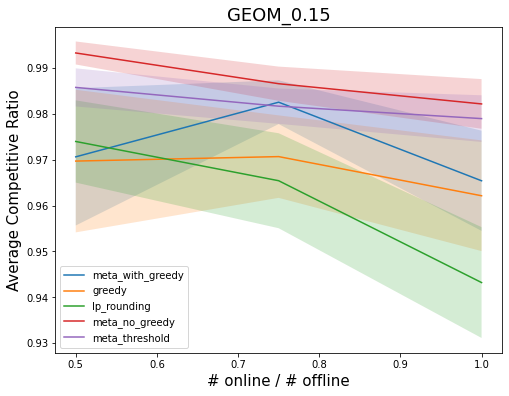

In [161]:
graph_configs = [
    {
        'graph_type': 'OSMNX',
        'location': 'Piedmont, California, USA'
    },
     {
        'graph_type': 'OSMNX',
        'location': 'Fremont, California, USA'
    },
    {
        'graph_type': 'GM'
    },
    {
        'graph_type': 'ER',
        'p': 0.25,
        'weighted': True
    },
    {
        'graph_type': 'ER',
        'p': 0.5,
        'weighted': True
    },
    {
        'graph_type': 'ER',
        'p': 0.75,
        'weighted': True
    },
    {
        'graph_type': 'BA',
        'ba_param': 4,
        'weighted': True
    },
    {
        'graph_type': 'BA',
        'ba_param': 6,
        'weighted': True
    },
    {
        'graph_type': 'BA',
        'ba_param': 8,
        'weighted': True
    },
    {
        'graph_type': 'GEOM',
        'q': 0.15,
        'd': 2,
        'weighted': True
    }
]

test = load_meta_experiments(graph_configs)
_plot_approx_ratios(ratios, test, lambda graph_type: graph_type, confidence = 0.95)

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


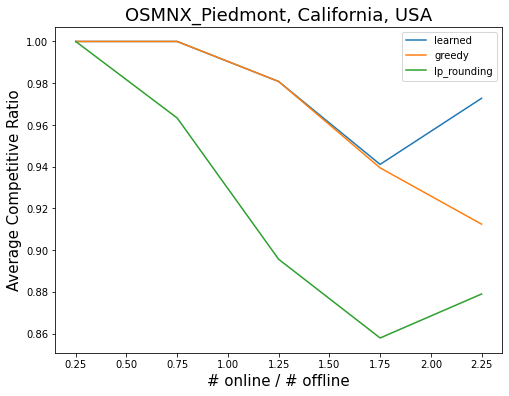

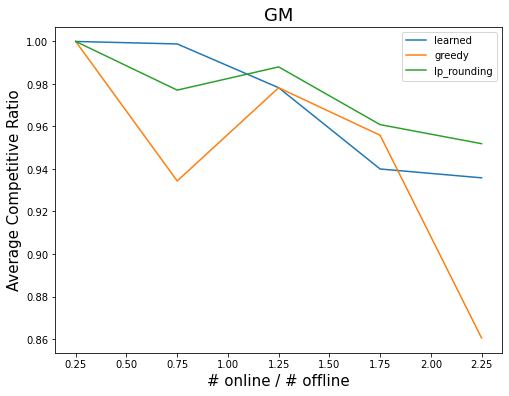

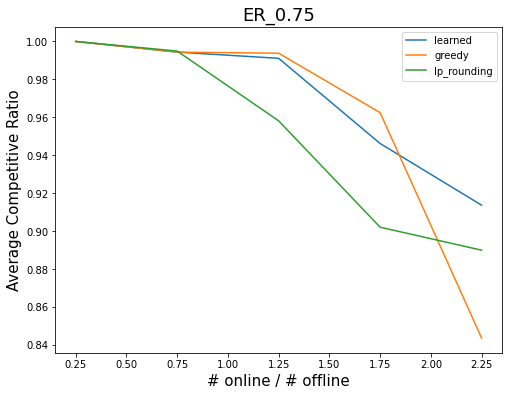

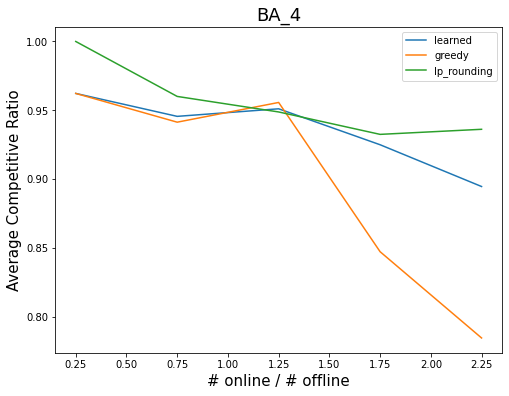

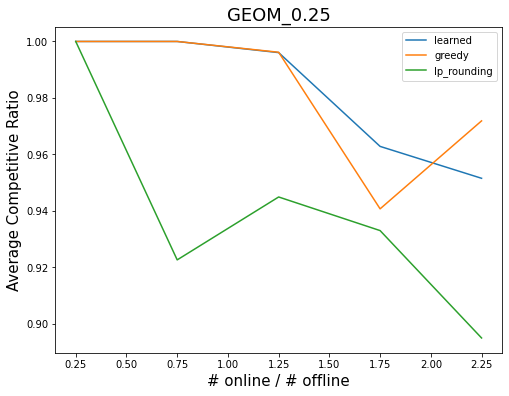

In [47]:
def _plot_approx_ratios(ratios, data, naming_function = lambda graph_type: graph_type, x_axis_name = "# online / # offline", confidence = 0.99):

    for graph_type, graph_data in data.items():
        aggregated_ratios = {}

        for model, ratios in graph_data.items():
            if model != 'num_trials':
                
            for model, ratio_values in trial_ratios.items():
                current_ratios = aggregated_ratios.get(model, [])
                
                # Compute the confidence interval for the competitive ratios
                ci_lowerbound, ci_upperbound = st.norm.interval(alpha=confidence, 
                                loc=np.mean(ratio_values), 
                                scale=st.sem(ratio_values)) 
                current_ratios.append((np.array(ratio_values).mean(), ci_lowerbound, ci_upperbound))
                aggregated_ratios[model] = current_ratios

        fig = plt.figure(figsize=(8,6))
        for model, model_ratios in aggregated_ratios.items():
            competitive_ratios = [val[0] for val in model_ratios]
            ci_lowerbounds = [val[1] for val in model_ratios]
            ci_upperbounds = [val[2] for val in model_ratios]
            plt.plot(ratios, competitive_ratios, label=model)
            plt.fill_between(ratios, ci_lowerbounds, ci_upperbounds, alpha = 0.2)

        title = f"{naming_function(graph_type)}"
        plt.title(title, fontsize = 18)
        plt.xlabel(x_axis_name, fontsize = 15)
        plt.ylabel('Average Competitive Ratio', fontsize = 15)
        plt.legend()
        plt.savefig(f"data/{title.replace(' ', '_')}.png")
        plt.show()

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


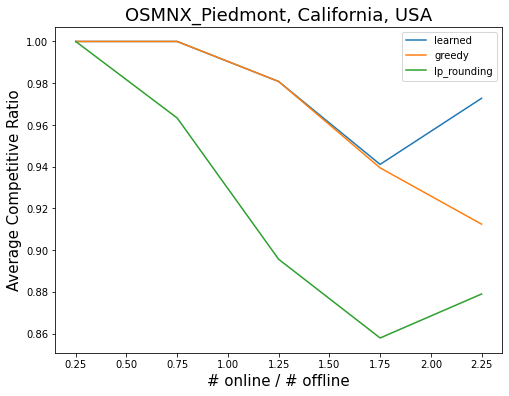

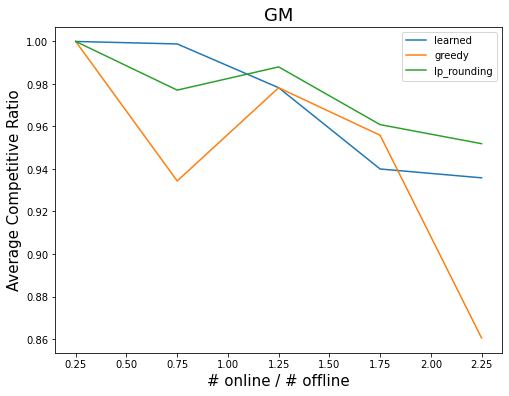

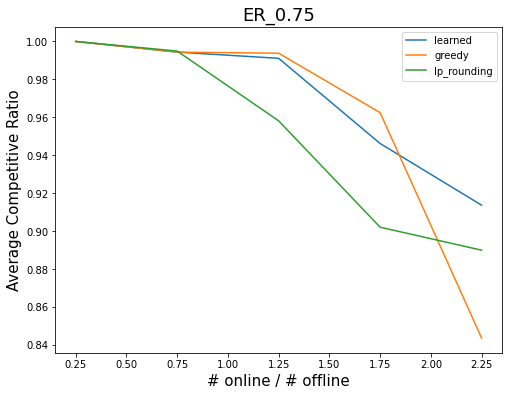

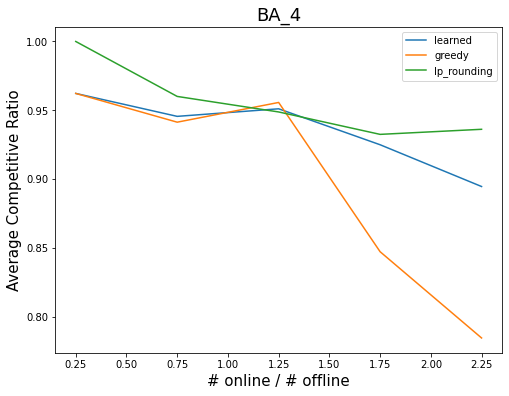

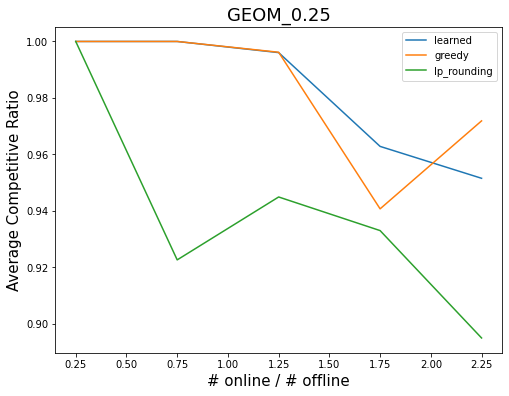

In [48]:
_plot_approx_ratios(ratios, data2, lambda graph_type: graph_type, confidence = 0.95)

In [ ]:
print(np.max(comp[:2, :], axis=1).mean())
print(comp.mean(axis=0))

In [ ]:
index1 = np.argmax(comp[:, 0] - comp[:, 1])
index2 = np.argmax(comp[:, 1] - comp[:, 0])

In [ ]:
tc._featurize(instances[index1])

In [ ]:
tc._featurize(instances[index2])

In [ ]:
GNN2_features = []
GNN1_features = []
for i, boolean in enumerate(comp[:, 1] > comp[:, 0]):
    if boolean:
        GNN2_features.append(tc._featurize(instances[i]))
    else:
        GNN1_features.append(tc._featurize(instances[i]))

out1 = np.vstack(GNN1_features)
out2 = np.vstack(GNN2_features)


In [ ]:
out1.mean(axis=0)

In [ ]:
out2.mean(axis=0)